### AutoEmulate for Reaction-Diffusion system

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import autoemulate as ae
from tqdm import tqdm

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.greyscott import simulate_greyscott
from autoemulate.compare import AutoEmulate

load_data = False

/Users/pconti/Desktop/AutoEmulator/autoemulate/autoemulate/compare.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Simulate/Load data

Run simulator


100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


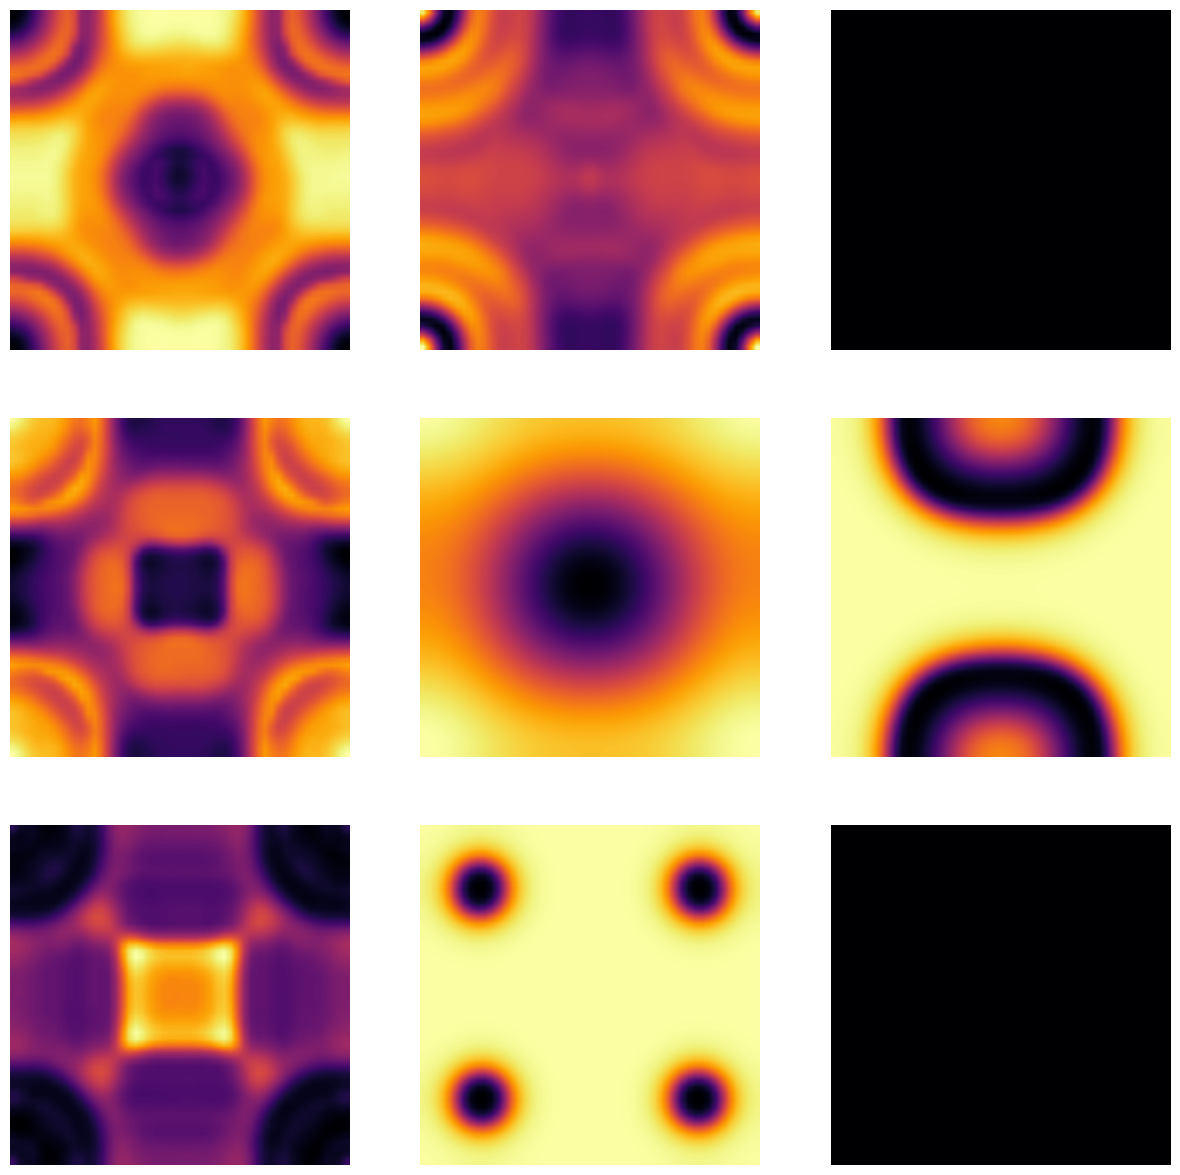

shapes: input X: (50, 2), output y: (50, 2500)



In [ ]:
if load_data:
    print("Load data")
    # TODO: make data path relative and upload data to the repo
    # Read inputs
    input_path = '/Users/pconti/Desktop/AutoEmulator/ModularCirc/TestPaolo/input_data.npy'
    X = np.load(input_path)
    n_samples, n_param = X.shape

    # Read outputs
    output_path = '/Users/pconti/Desktop/AutoEmulator/ModularCirc/TestPaolo/output_data.npy'
    y = np.load(output_path)
    y = y.reshape(n_samples, -1)

    print(f"shapes: input X: {X.shape}, output y: {y.shape}\n")

else:
    print("Run simulator")
    seed = 1
    np.random.seed(seed)

    f_range = (.02, .08) # range for feed rate
    k_range = (.04, .07) # range for kill rate
    lhd = LatinHypercube([f_range, k_range])
    n_samples = 50
    grid_size = 50
    X = lhd.sample(n_samples)
    # Run simulation
    U, V = zip(*[simulate_greyscott(p, size = grid_size, dt =.1, steps=5000) for p in tqdm(X)])

    U = np.stack(U)
    V = np.stack(V)

    plt.figure(figsize=(15,15))
    for i in range(9):
        plt.subplot(3,3,1+i)
        plt.imshow(U[i], cmap="inferno", interpolation='bilinear')
        plt.axis('off')
    plt.show()

    U = U.reshape((n_samples, -1))
    V = V.reshape((n_samples, -1))

    y = U

    print(f"shapes: input X: {X.shape}, output y: {y.shape}\n")

# Retain data for testing
x_test = X[:10]
y_test = y[:10]
# Remainings are for training
X = X[10:]
y = y[10:]



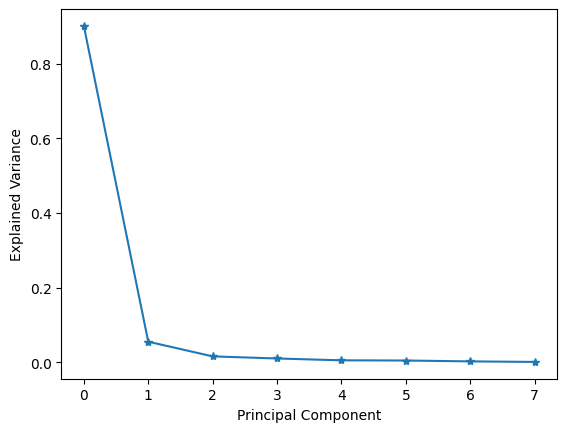

(40, 8)


In [5]:
# Perform PCA on the output data
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
y_pca = pca.fit_transform(y)

# Plot the explained variance
plt.plot(pca.explained_variance_ratio_,'*-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

print(y_pca.shape)

# Plot the PCA
#plt.scatter(y_pca[:,0], y_pca[:,1])
#plt.show()

In [6]:
## AUTOEMULATE
# inputs are standardised (scale = True)
# 5-fold cross-validation
from sklearn.model_selection import KFold

em = AutoEmulate()
em.setup(X, y, reduce_dim_output=True, dim_reducer_output=PCA(n_components=8), models=['gp'])#,  cross_validator=kfold)
best_model = em.compare()

,Values
Simulation input shape (X),"(40, 2)"
Simulation output shape (y),"(40, 2500)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),True
Dimensionality output reduction method (dim_reducer_output),PCA
Cross validator (cross_validator),KFold


Initializing:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
em.summarise_cv()

,model,short,rmse,r2
0,GaussianProcess,gp,0.148232,0.467126


In [8]:
#look at each of the cv-folds for a specific model, like GP
em.summarise_cv(model='GaussianProcess')

,fold,rmse,r2
0,0,0.138207,0.816284
1,1,0.099750,-0.467422
2,2,0.169887,0.668834
3,3,0.201139,0.533859
4,4,0.132175,0.784075


Plotting the output variable with index 0. 
To plot other outputs, set `output_index` argument to the desired index.
Plotting the output variable with index 2. 
To plot other outputs, set `output_index` argument to the desired index.


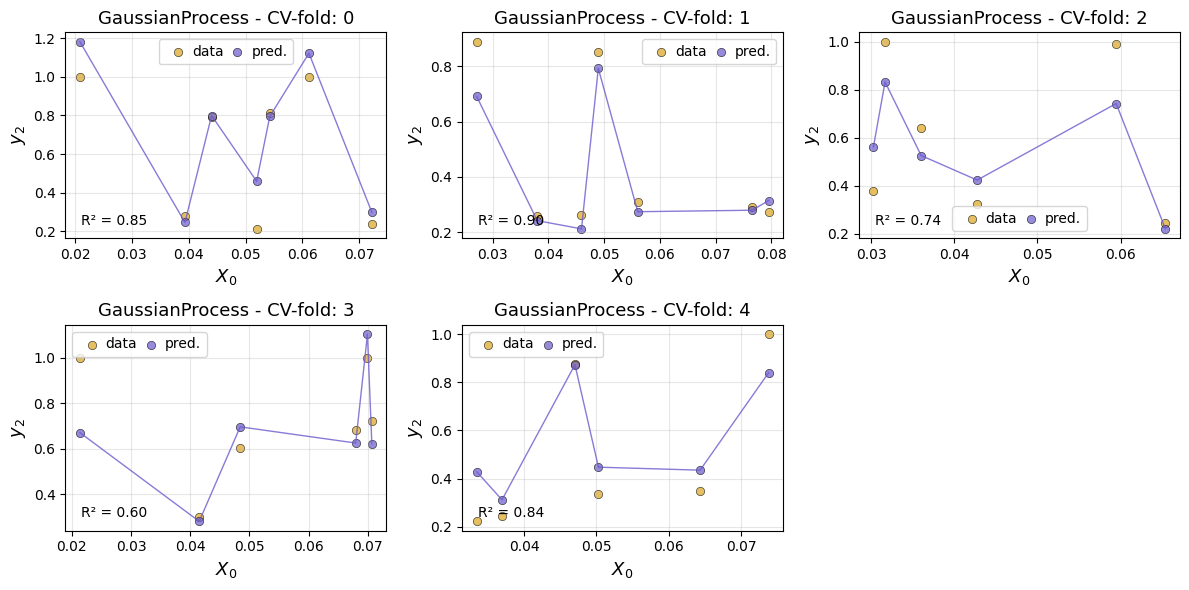

In [9]:
# To inspect spceific models more closely, we can plot the predictions for each cv fold for a given model

# Performance in predicting the first PCA component wrt first parameter (reaction beta)
PCA_component = 0
em.plot_cv(model='GaussianProcess', input_index=0, output_index=PCA_component)

# Performance in predicting the third PCA component wrt first parameter (reaction beta)
PCA_component = 2
em.plot_cv(model='GaussianProcess', input_index=0, output_index=PCA_component)


Plotting the output variable with index 0. 
To plot other outputs, set `output_index` argument to the desired index.


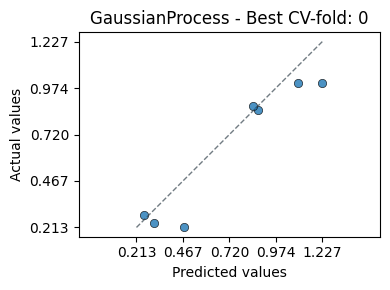

In [10]:
em.plot_cv(style="actual_vs_predicted")

Plotting the output variable with index 0. 
To plot other outputs, set `output_index` argument to the desired index.


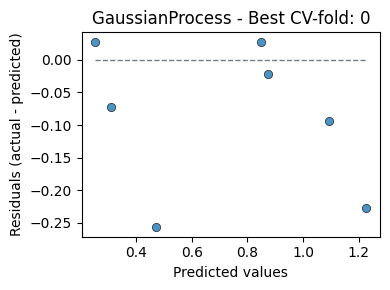

In [11]:
#Inspect the residuals too to spot any patterns
em.plot_cv(style="residual_vs_predicted")

In [12]:
## 3) Evaluate the emulator (on the test set)
gp = em.get_model('GaussianProcess')
em.evaluate(gp)

,model,short,rmse,r2
0,GaussianProcess,gp,0.1094,0.8927


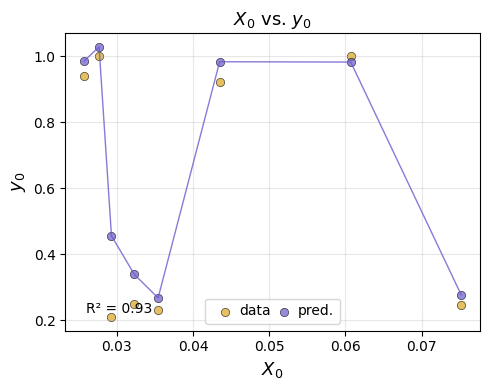

In [13]:
em.plot_eval(gp, input_index=0, output_index=0)

In [14]:
## 4) Refit the emulator model on the full data
gp_final = em.refit(gp)

## Prediction on the test set

In [15]:
# Predict on the test set
#y_pred_pca = gp_final.predict(x_test)
y_pred = gp_final.predict(x_test)

# Reconstruction of the original data
#y_pred = pca.inverse_transform(y_pred_pca)

In [17]:
y_pred_plot = y_pred.reshape((n_simulations, 50, 50))

NameError: name 'n_simulations' is not defined

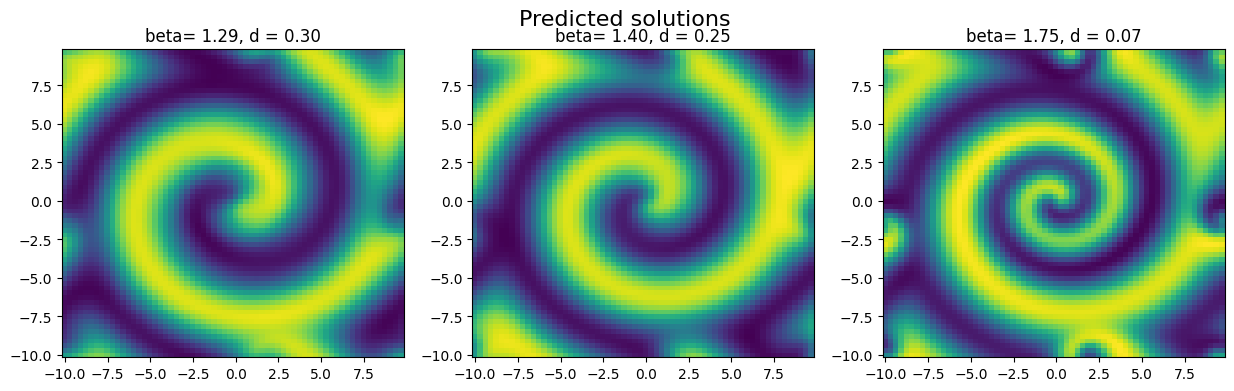

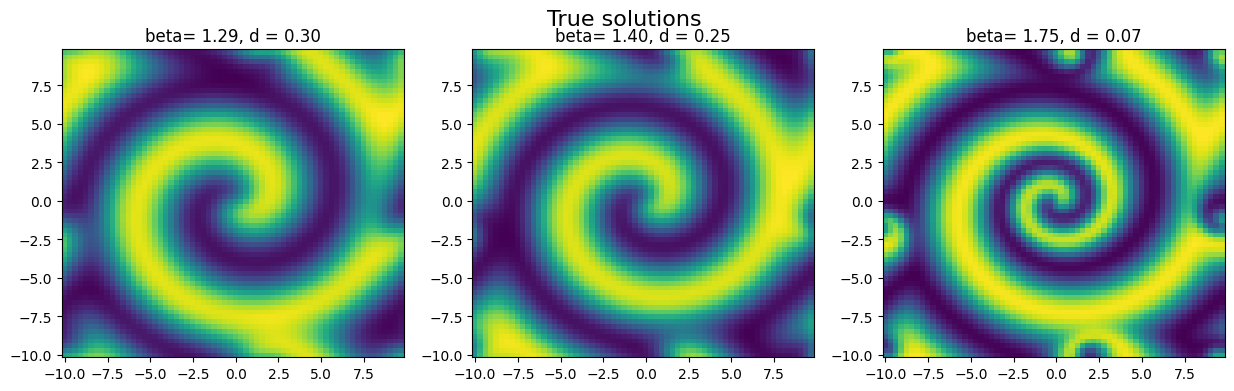

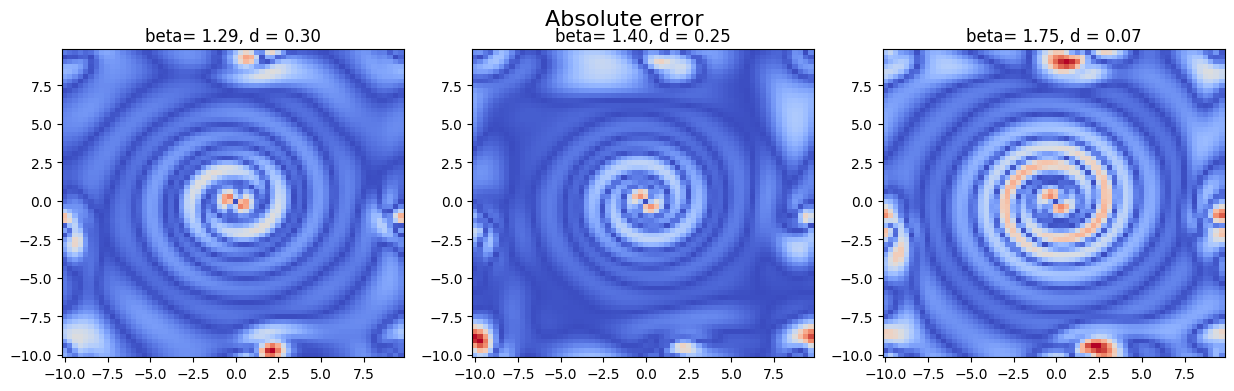

In [14]:
# Plot the predicted and true solutions
plot_reactiondiffuison(x_test, y_pred, title='Predicted solutions')
plot_reactiondiffuison(x_test, y_test, title='True solutions')

# Plot the absolute error
plot_reactiondiffuison(x_test, np.abs(y_pred - y_test), title='Absolute error', cmap='coolwarm')